# How to Python Web Scrape the Nasdaq Stock Ex-Dividend Calendar

https://medium.com/c%C3%B3digo-ecuador/how-to-python-web-scrape-the-nasdaq-stock-ex-dividend-calendar-648b6063c659

Web scrape a list of stocks with upcoming ex-dividend dates from the Nasdaq API using the Python pandas, requests, datetime, and calendar modules.

## Install & import required Python packages

You will need the pandas, requests, datetime, and calendar modules to web scrape a list of stocks with upcoming ex-dividend dates from the Nasdaq API using the Python coding language. 


In [50]:
import pandas, requests, calendar
import datetime as dt
import pandas_datareader.data as web
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import style
import yfinance as yf
from tqdm import tqdm # progress
import numpy as np
import pandas as pd

style.use('ggplot')
mpl.rcParams['figure.figsize'] = (16.0, 9.0)
mpl.rcParams['font.size'] = 12
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'

class dividend_calendar:
    #class attributes 
    calendars = [] 
    url = 'https://api.nasdaq.com/api/calendar/dividends'
    hdrs =  {'Accept': 'application/json, text/plain, */*',
                 'DNT': "1",
                 'Origin': 'https://www.nasdaq.com/',
                 'Sec-Fetch-Mode': 'cors',
                 'User-Agent': 'Mozilla/5.0 (Windows NT 10.0)'}
    def __init__(self, year, month):
        '''
        Parameters
        ----------
        year : year int
        month : month int

        Returns
        -------
        Sets instance attributes for year and month of object.

        '''
        #instance attributes
        self.year = int(year)
        self.month = int(month)

    def date_str(self, day):
        date_obj = dt.date(self.year, self.month, day)
        date_str = date_obj.strftime(format='%Y-%m-%d')     
        return date_str
    
    def scraper(self, date_str):
        ''' 
        Scrapes JSON object from page using requests module.
          
        Parameters
        - - - - - 
        url : URL string
        hdrs : Header information
        date_str: string in yyyy-mm-dd format
             
        Returns
        - - - -
        dictionary : Returns a JSON dictionary at a given URL.
         
        '''
        params = {'date': date_str}
        page=requests.get(self.url,headers=self.hdrs,params=params)
        dictionary = page.json()
        return dictionary
    
    def dict_to_df(self, dicti):
        ''' 
        Converts the JSON dictionary into a pandas dataframe
        Appends the dataframe to calendars class attribute         
        
        Parameters
        ----------
        dicti : Output from the scraper method as input.
        
        Returns
        -------
        calendar : Dataframe of stocks with that exdividend date
        
        Appends the dataframe to calendars class attribute
        
        If the date is formatted correctly, it will append a 
        dataframe to the calendars list (class attribute).  
        Otherwise, it will return an empty dataframe.         
        '''
         
        rows = dicti.get('data').get('calendar').get('rows')
        calendar = pandas.DataFrame(rows)
        self.calendars.append(calendar)
        return calendar
   
            
    def calendar(self, day):
        '''
        Combines the scrape and dict_to_df methods
        
        Parameters
        ----------
        day : day of the month as string or number.
        
        Returns
        -------
        dictionary : Returns a JSON dictionary with keys 
        dictionary.keys() => data, message, status
        
        Next Levels: 
        dictionary['data'].keys() => calendar, timeframe
        dictionary['data']['calendar'].keys() => headers, rows
        dictionary['data']['calendar']['headers'] => column names
        dictionary['data']['calendar']['rows'] => dictionary list
    
        '''
        day = int(day)
        date_str = self.date_str(day)      
        dictionary = self.scraper(date_str)
        self.dict_to_df(dictionary)          
        return dictionary
           
if __name__ == '__main__':
    year = 2020
    month = 9

    day_today = int(dt.datetime.now().strftime("%d"))
    
#get number of days in month
    days_in_month = calendar.monthrange(year, month)[1]
#create calendar object    
    february = dividend_calendar(year, month)
#define lambda function to iterate over list of days     
    function = lambda days: february.calendar(days)
    
#define list of ints between 1 and the number of days in the month
    iterator = list(range(1, days_in_month+1))
#     iterator = list(range(day_today+1, days_in_month+1))
#Scrape calendar for each day of the month                    
    objects = list(map(function, iterator))
#concatenate all the calendars in the class attribute
    concat_df = pandas.concat(february.calendars)
    
#Drop any rows with missing data
    drop_df = concat_df.dropna(how='any')
    
#set the dataframe's row index to the company name
    final_df = drop_df.set_index('companyName')

# print(final_df.info())
# print(final_df.tail())

In [51]:
# print(yf.Ticker("AAPL").info)
# print(yf.Ticker("AAPL").recommendations)
# print(yf.Ticker("ACN").history(start=dt.datetime(2010, 1, 1), end=dt.datetime.now()))
# print(yf.Ticker("ACN").history("max"))

In [52]:
today_price = []
today_volume = []

for symbol in tqdm(list(final_df['symbol'])):
    symbol = symbol.replace('.', '-')
    company = yf.Ticker(symbol)
    df2 = company.history(period="7d")
    df2.dropna(inplace=True)
    today_price.append(df2.iloc[-1, df2.columns.get_loc('Close')])
    today_volume.append(df2.iloc[-1, df2.columns.get_loc('Volume')])

today_time = dt.datetime.now()
final_df[today_time] = today_price
final_df['Volume'] = today_volume
div_perc= final_df['dividend_Rate'] / final_df[today_time] * 100.0
final_df.insert(2, 'Dividend Percent', div_perc)


100%|████████████████████████████████████████████████████████████████████████████████| 465/465 [03:02<00:00,  2.55it/s]


                                                symbol dividend_Ex_Date  \
companyName                                                               
Arrow Financial Corporation                       AROW       09/01/2020   
Everest Re Group, Ltd.                              RE       09/01/2020   
First Trust Senior Floating Rate Income Fund II    FCT       09/01/2020   
Fox Corporation                                   FOXA       09/01/2020   
Fox Corporation                                    FOX       09/01/2020   
...                                                ...              ...   
Cardinal Health, Inc.                              CAH       09/30/2020   
Consolidated Water Co. Ltd.                       CWCO       09/30/2020   
CubeSmart                                         CUBE       09/30/2020   
Farmland Partners Inc.                             FPI       09/30/2020   
Wabash National Corporation                        WNC       09/30/2020   

                        

(0.0, 5.0)

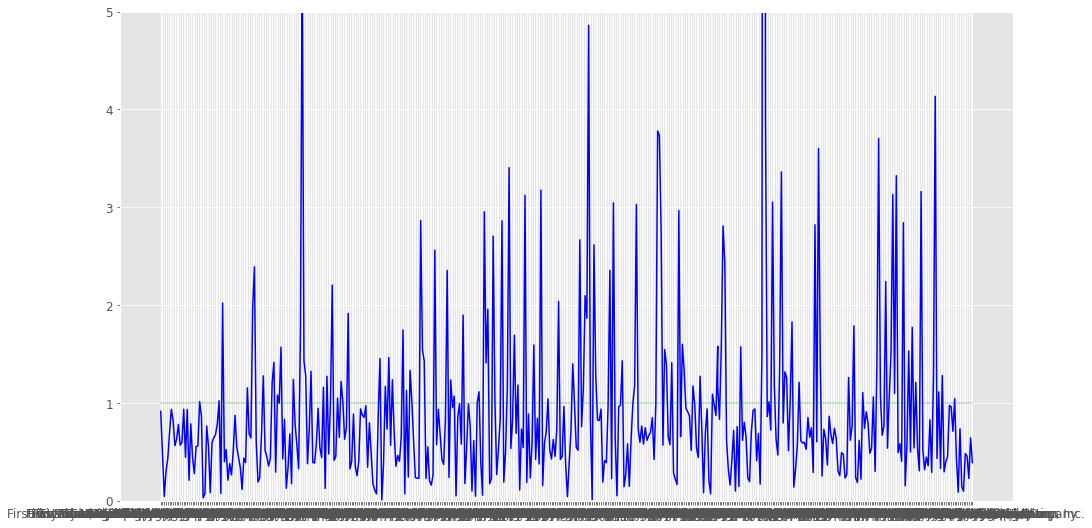

In [59]:
# Output all stocks that dividend > threshold
threshold = 0.5
print(final_df[final_df['Dividend Percent'] >= threshold])

# reorder columns
print(final_df.columns)
final_df = final_df[['symbol', 'dividend_Ex_Date', 'Dividend Percent', 'Volume', 
                     today_time, 'dividend_Rate', 'indicated_Annual_Dividend',
                    'payment_Date', 'record_Date', 'announcement_Date']]

# final_df[final_df['Dividend_Perc'] >= threshold].to_csv('stock_dividend.csv')
final_df[final_df['Dividend Percent'] >= threshold].to_csv('stock_dividend_{}_{}.csv'.format(month, day_today))

plt.plot(final_df['Dividend Percent'], color='blue')
plt.plot(final_df.index, [1]*len(final_df.index), color='green', alpha=0.25)
plt.ylim([0, 5])

In [54]:
'''
start = dt.datetime(year, month, 1)
end = dt.datetime.now()
start = end - dt.timedelta(days=7)
today_price = []

for symbol in list(final_df['symbol']):
    symbol = symbol.replace('.', '-')
    df2 = web.DataReader(symbol, 'yahoo', start, end)
    df2.reset_index(inplace=True)
    df2.set_index("Date", inplace=True)
    today_price.append(df2.iloc[-1, df2.columns.get_loc('Adj Close')])
    
# print(len(final_df.index), len(today_price))
# print(today_price)
final_df['Today_Price'] = today_price
    
print(final_df.tail())
'''

'\nstart = dt.datetime(year, month, 1)\nend = dt.datetime.now()\nstart = end - dt.timedelta(days=7)\ntoday_price = []\n\nfor symbol in list(final_df[\'symbol\']):\n    symbol = symbol.replace(\'.\', \'-\')\n    df2 = web.DataReader(symbol, \'yahoo\', start, end)\n    df2.reset_index(inplace=True)\n    df2.set_index("Date", inplace=True)\n    today_price.append(df2.iloc[-1, df2.columns.get_loc(\'Adj Close\')])\n    \n# print(len(final_df.index), len(today_price))\n# print(today_price)\nfinal_df[\'Today_Price\'] = today_price\n    \nprint(final_df.tail())\n'

In [56]:
'''
# Original script

import pandas, requests, datetime, calendar
class dividend_calendar:
    #class attributes 
    calendars = [] 
    url = 'https://api.nasdaq.com/api/calendar/dividends'
    hdrs =  {'Accept': 'application/json, text/plain, */*',
                 'DNT': "1",
                 'Origin': 'https://www.nasdaq.com/',
                 'Sec-Fetch-Mode': 'cors',
                 'User-Agent': 'Mozilla/5.0 (Windows NT 10.0)'}
def __init__(self, year, month):
          '''
        Parameters
        ----------
        year : year int
        month : month int
        
        Returns
        -------
        Sets instance attributes for year and month of object.
        
          '''
          #instance attributes
          self.year = int(year)
          self.month = int(month)
     
     def date_str(self, day):
          date_obj = datetime.date(self.year, self.month, day)
          date_str = date_obj.strftime(format='%Y-%m-%d')     
          return date_str
     def scraper(self, date_str):
         ''' 
          Scrapes JSON object from page using requests module.
           
           Parameters
           - - - - - 
           url : URL string
           hdrs : Header information
           date_str: string in yyyy-mm-dd format
               
           Returns
           - - - -
           dictionary : Returns a JSON dictionary at a given URL.
         
         '''
         params = {'date': date_str}
         page=requests.get(self.url,headers=self.hdrs,params=params)
         dictionary = page.json()
         return dictionary
    
     def dict_to_df(self, dicti):
         ''' 
         Converts the JSON dictionary into a pandas dataframe
         Appends the dataframe to calendars class attribute         
         
         Parameters
         ----------
         dicti : Output from the scraper method as input.
         
         Returns
         -------
         calendar : Dataframe of stocks with that exdividend date
         
         Appends the dataframe to calendars class attribute
         
         If the date is formatted correctly, it will append a 
         dataframe to the calendars list (class attribute).  
         Otherwise, it will return an empty dataframe.         
         '''
         
         rows = dicti.get('data').get('calendar').get('rows')
         calendar = pandas.DataFrame(rows)
         self.calendars.append(calendar)
         return calendar
   
            
    def calendar(self, day):
          '''
          Combines the scrape and dict_to_df methods
          
          Parameters
          ----------
          day : day of the month as string or number.
          
          Returns
          -------
          dictionary : Returns a JSON dictionary with keys 
          dictionary.keys() => data, message, status
          
          Next Levels: 
          dictionary['data'].keys() => calendar, timeframe
          dictionary['data']['calendar'].keys() => headers, rows
          dictionary['data']['calendar']['headers'] => column names
          dictionary['data']['calendar']['rows'] => dictionary list
    
          '''
          day = int(day)
          date_str = self.date_str(day)      
          dictionary = self.scraper(date_str)
          self.dict_to_df(dictionary)          
          return dictionary
           
if __name__ == '__main__':
    year = 2020
    month = 2
    
#get number of days in month
    days_in_month = calendar.monthrange(year, month)[1]
#create calendar object    
    february = dividend_calendar(year, month)
#define lambda function to iterate over list of days     
    function = lambda days: february.calendar(days)
    
#define list of ints between 1 and the number of days in the month
    iterator = list(range(1, days_in_month+1))
#Scrape calendar for each day of the month                    
    objects = list(map(function, iterator))
#concatenate all the calendars in the class attribute
    concat_df = pandas.concat(february.calendars)
    
#Drop any rows with missing data
    drop_df = concat_df.dropna(how='any')
    
#set the dataframe's row index to the company name
    final_df = drop_df.set_index('companyName')
'''

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 48)